In [4]:
%pip install nltk

%pip install spacy
!python -m spacy download es_core_news_sm



Note: you may need to restart the kernel to use updated packages.


  Using cached spacy-3.8.7-cp311-cp311-win_amd64.whl (14.9 MB)
  Using cached murmurhash-1.0.13-cp311-cp311-win_amd64.whl (24 kB)
  Using cached preshed-3.0.10-cp311-cp311-win_amd64.whl (117 kB)
  Using cached thinc-8.3.6-cp311-cp311-win_amd64.whl (1.8 MB)
  Using cached srsly-2.5.1-cp311-cp311-win_amd64.whl (632 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
  Using cached weasel-0.4.1-py3-none-any.whl (50 kB)
  Using cached typer-0.19.2-py3-none-any.whl (46 kB)
  Using cached pydantic-2.12.0-py3-none-any.whl (459 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl (182 kB)
  Using cached language_data-1.3.0-py3-none-any.whl (5.4 MB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
  Using cached blis-1.3.0-cp311-cp311-win_amd64.whl (6.2 MB)
  Using cached confection-0.1.5-py3-none-any.whl (35 kB)
  Using cached rich-14.2.0-py3-none-any.whl (243 kB)
  Using cached cloudpathlib-0.23.0-py3-none-any.whl (62 kB)
  Using cached marisa_trie-1.3.1-cp311-cp311-win_a

     --------------------------------------- 12.9/12.9 MB 28.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [6]:
%pip install wordcloud

     -------------------------------------- 299.9/299.9 kB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import nltk
import re
import unicodedata
import spacy
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
#from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
for model_name in [
    "facebook/bart-large-mnli",        # para stance pro-ruso/pro-ucraniano
    "valhalla/distilbart-mnli-12-1"    # para ejes argumentativos
]:
    print(f"Descargando {model_name}…")
    AutoTokenizer.from_pretrained(model_name)
    AutoModelForSequenceClassification.from_pretrained(model_name)
print("✓ Modelos descargados en caché local.")

Descargando facebook/bart-large-mnli…


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Descargando valhalla/distilbart-mnli-12-1…
✓ Modelos descargados en caché local.


In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# 2. Carga el analizador
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [2]:
df = pd.read_csv("../data/processed/2_comments_youtube_refined.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371809 entries, 0 to 371808
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   comment_id                   371809 non-null  object 
 1   comment                      371809 non-null  object 
 2   comment_text_length          371809 non-null  int64  
 3   user_id                      371809 non-null  object 
 4   user_name                    371809 non-null  object 
 5   comment_time                 371809 non-null  object 
 6   comment_likes                371809 non-null  int64  
 7   total_reply_count            371809 non-null  int64  
 8   is_top_level_comment         371809 non-null  bool   
 9   video_title                  371809 non-null  object 
 10  channel_title                371809 non-null  object 
 11  video_published_at           371809 non-null  object 
 12  video_views                  371809 non-null  int64  
 13 

In [4]:
# Colores personalizados
colors = {
    'noticiero': 'grey',
    'pro-ruso': 'red',
    'pro-ucraniano': 'blue'
}

# Nube de Palabras

In [5]:
# 1) Lista manual de stopwords en español (puedes ampliarla si quieres)
spanish_stopwords = [
    "de","la","que","el","en","y","a","los","del","se","las","por","un","para",
    "con","no","una","su","al","lo","como","más","pero","sus","le","ya","o","este",
    "sí","porque","esta","entre","cuando","muy","sin","sobre","también","me","hasta",
    "hay","donde","quien","desde","todo","nos","durante","todos","uno","les","ni",
    "contra","otros","ese","eso","ante","ellos","e","esto","mí","antes","algunos",
    "qué","unos","yo","otro","otras","otra","él","tanto","esa","estos","mucho",
    "quienes","nada","muchos","cual","poco","ella","estar","estas","algunas","algo",
    "nosotros","mi","mis","tú","te","ti","tu","tus","ellas","nosotras","vosotros",
    "vosotras","os","mío","mía","míos","mías","tuyo","tuya","tuyos","tuyas","suyo",
    "suya","suyos","suyas","nuestro","nuestra","nuestros","nuestras","vuestro",
    "vuestra","vuestros","vuestras","esos","esas", "es", "ser", "fue", "son", "sido", "tiene", "tenido", "tienen", "tenía",
    "tenían", "tendría", "tendrían", "había", "habían", "habrá", "habrán", "habría", "son", "serán", "sería", "serían",
    "está", "están", "estuve", "estuvieron", "estaría", "estarían", "esté", "estén", "estuviera", "estuvieran", 
    "mas", "q", "solo", "tiene", "tienen", "si", "no", "estan", "va", "ha", "vivo", "viva", "ahora", "asi", "aqui", "ahi", 
    "siempre", "nunca", "ya", "sabe", "misma", "tambien", "era", "ve", "dio", "fueron", "toda", "misma", "hacer", "entonces", 
    "iran", "cosa", "dice"
]

In [6]:
# 2) Función para normalizar texto (minúsculas + sin tildes)
def normalize_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text)
    return ''.join(c for c in text if not unicodedata.combining(c))

In [7]:
# 3) Recolectar y filtrar tokens de todos los comentarios
tokens = []
for txt in df['comment'].astype(str):
    norm = normalize_text(txt)
    toks = re.findall(r"\b\w+\b", norm)
    tokens.extend([t for t in toks if t not in spanish_stopwords])

In [8]:
# 4) Contar frecuencias y tomar top 20
counts = Counter(tokens).most_common(20)
words, freqs = zip(*counts)

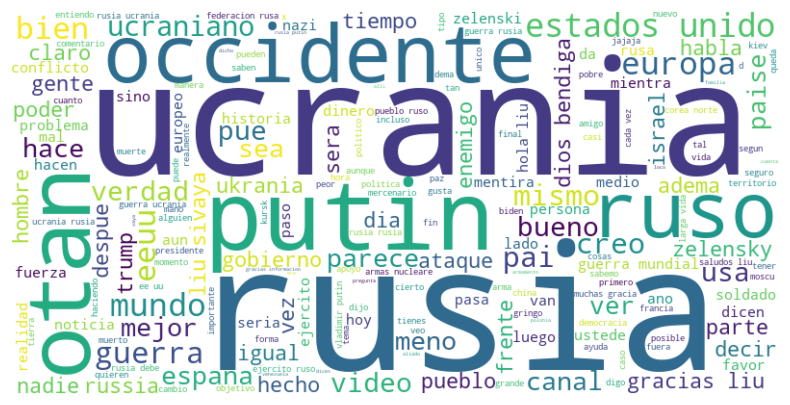

In [9]:
text = " ".join(tokens)
wc = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
# 1) Extraemos tokens para cada categoría
tokens_noticiero = []
for txt in df[df['condiciones_cuenta']=='noticiero']['comment'].astype(str):
    norm = normalize_text(txt)
    toks = re.findall(r"\b\w+\b", norm)
    tokens_noticiero.extend([t for t in toks if t not in spanish_stopwords])

tokens_proruso = []
for txt in df[df['condiciones_cuenta']=='pro-ruso']['comment'].astype(str):
    norm = normalize_text(txt)
    toks = re.findall(r"\b\w+\b", norm)
    tokens_proruso.extend([t for t in toks if t not in spanish_stopwords])

tokens_proucraniano = []
for txt in df[df['condiciones_cuenta']=='pro-ucraniano']['comment'].astype(str):
    norm = normalize_text(txt)
    toks = re.findall(r"\b\w+\b", norm)
    tokens_proucraniano.extend([t for t in toks if t not in spanish_stopwords])

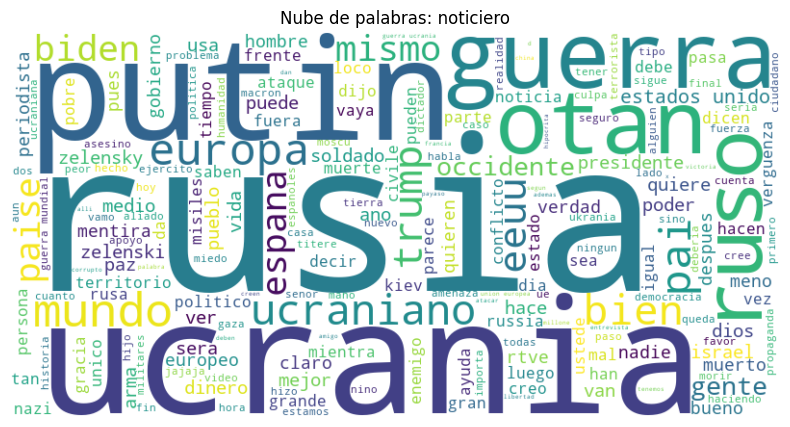

In [11]:
# Nube de palabras para “noticiero”
text_noticiero = " ".join(tokens_noticiero)
wc = WordCloud(width=800, height=400, background_color="white").generate(text_noticiero)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras: noticiero")
plt.show()

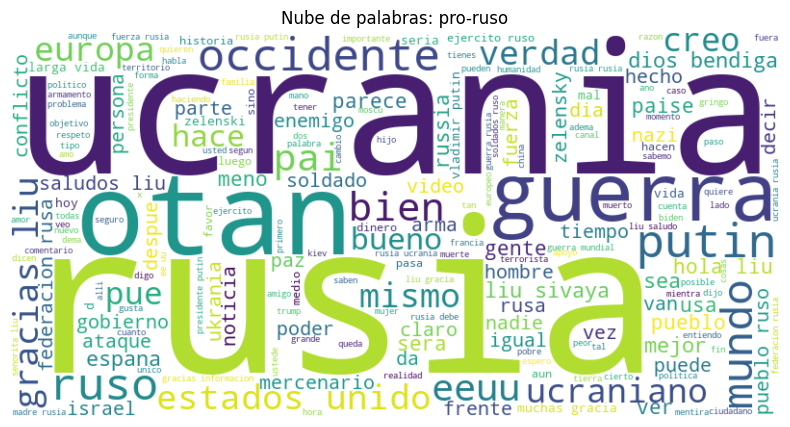

In [12]:
# Nube de palabras para “pro-ruso”
text_proruso = " ".join(tokens_proruso)
wc = WordCloud(width=800, height=400, background_color="white").generate(text_proruso)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras: pro-ruso")
plt.show()

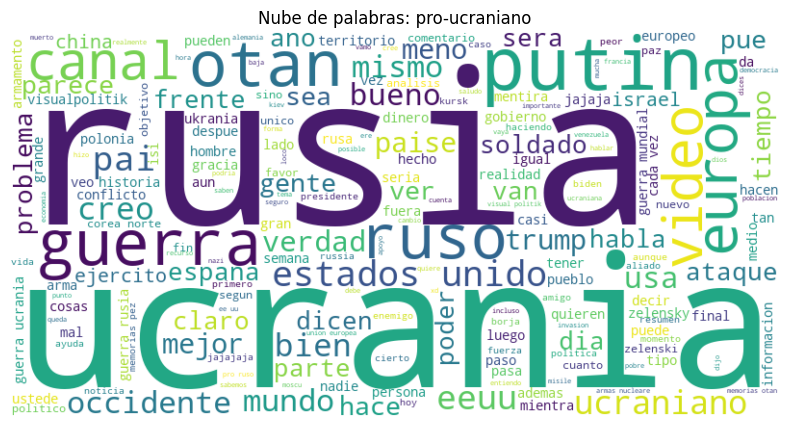

In [13]:
# Nube de palabras para “pro-ucraniano”
text_proucr = " ".join(tokens_proucraniano)
wc = WordCloud(width=800, height=400, background_color="white").generate(text_proucr)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras: pro-ucraniano")
plt.show()

# Classificación -1 a 1 de sentimientos

In [4]:
# 3. Función que mapea a -1, 0, 1 según el 'compound'
def sentiment_label_vader(text, low= -0.05, high=0.05):
    s = sia.polarity_scores(text)['compound']
    if s >= high: return  1
    if s <= low:  return -1
    return 0

In [5]:
df['sentiment'] = df['comment'].astype(str).apply(sentiment_label_vader)

In [6]:
# Conteos absolutos y relativos
counts = df['sentiment'].value_counts().sort_index()
props  = df['sentiment'].value_counts(normalize=True).sort_index() * 100

print("Counts:\n", counts)
print("\nPercentages:\n", props.round(2))


Counts:
 sentiment
-1    34969
 0    72563
 1     6244
Name: count, dtype: int64

Percentages:
 sentiment
-1    30.73
 0    63.78
 1     5.49
Name: proportion, dtype: float64


In [7]:
for s in [-1, 0, 1]:
    print(f"\n=== Clase {s} ===")
    ejemplos = df[df['sentiment']==s]['comment'].sample(5, random_state=42).tolist()
    for c in ejemplos:
        print("-", c)



=== Clase -1 ===
- Miguel 👏👏 estoy impactada 😢😢😢 😞😔 no puedo ni hablar.
- No entiendo nada por el canal prensa alternativa de Juan José del castillo publican que Rusia 🇷🇺 está acabando con los rebeldes los mig 31 y sucoy 35 están bombardeado sin piedad a los extremistas kurdos y por aquí dicen lo contrario así que no entiendo nada
- TU ERES PROCOMUNISMO JAJAJAJAJA YA VI VARIOS DE TUS VIDEOS Y TODOS USTEDES HACEN POSTURAS DE CONDOLENCIAS A GOBERNANTES COMUNISTAS, POBRE Y LAMENTABLE, PERO ESTA ES LA GRAN PRUEBA PARA LA HUMANIDAD EL COMUNISMO!!!!!, AL FINAL ESTO ES UNA BATALLA ESPIRITUAL Y DE UNA VES DE AVISO EL COMUNISMO YA PERDIO Y TU PARECE SER QUE TE INCLINAS POR UN BANDO PERDEDOR!
- No todo van a ser malas noticias para Rusia dice...y si no fuera por la OTAN Ucrania se mea encima y aun así solo esta consiguiendo una mierda bien gorda.
- Estos cretinos no son concientes que están abriendo las puertas del INFIERNO para la humanidad, los ciudadanos europeos deben rechazar este tipo de 

In [8]:
tabla = (
    df
    .groupby(['condiciones_cuenta', 'sentiment'])
    .size()
    .unstack(fill_value=0)
)
print(tabla)

sentiment              -1      0     1
condiciones_cuenta                    
noticiero            7862  17333  1214
pro-ruso            16776  35988  2869
pro-ucraniano       10331  19242  2161


In [9]:
tabla_pct = tabla.div(tabla.sum(axis=1), axis=0).round(3)*100
print(tabla_pct)

sentiment             -1     0    1
condiciones_cuenta                 
noticiero           29.8  65.6  4.6
pro-ruso            30.2  64.7  5.2
pro-ucraniano       32.6  60.6  6.8


# Detección de “postura” (stance) pro-ruso vs pro-ucraniano

In [8]:
# 1) Creamos el pipeline (requiere descargar modelo la 1ª vez)
stance_classifier = pipeline(
    "zero-shot-classification",
    model="valhalla/distilbart-mnli-12-1",
    device=-1,
    batch_size=64,
    local_files_only=True
)

# 2) Etiquetas candidatas
candidate_labels = ["pro-ruso", "pro-ucraniano", "neutral"]

# 3) Función para asignar la etiqueta más probable
def detect_stance(text):
    out = stance_classifier(text, candidate_labels)
    return out["labels"][0]   # el label con mayor score

# 4) Aplica al DataFrame
df["stance"] = df["comment"].astype(str).apply(detect_stance)

Device set to use cpu


KeyboardInterrupt: 

# 2) Detección de insultos / toxicidad


In [14]:
# 1) Función para normalizar (quitar tildes y pasar a minúsculas)
def normalize_text(text):
    text = text.lower()
    # descomponer caracteres Unicode y quitar marcas
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    return text

In [15]:
# 1. Un set amplio de insultos comunes en español
insultos = {
    "idiota","imbécil","estúpido","estupida","tonto","tonta","bobo","boba",
    "gilipollas","gilipollas","gilipollas","gilipollas","burro","burra",
    "subnormal","retrasado","retrasada","tarado","tarada","mongólico",
    "mongolica","cretino","cretina","cabron","cabrón","cabrona","cabronazo",
    "pendejo","pendeja","maricón","marica","maricona","coño","joder","mierda",
    "puta","puto","maldito","maldita","malparido","malparida","zorra","perra",
    "prostituta","mamón","mamona","zopenco","zopenca","zángano","zorra","zoquete",
    "gilipuertas","capullo","capulla","troll","idiota","idiotas","inutil", "mentiroso",
    "gil",
    # contexto de guerra
    "traidor","genocida","asesino","criminal","invasor","nazis", "nazi", "ucranazi", "fascista",
    "marioneta","titere","miserable","cobarde","zombie", "rata", "ratas", "ladron",
    "ladrona", "complice", "fascista", "facho", "payaso", "otanazi", "ukronazi","ukrop"

}


In [16]:
# 3) Función para detectar insultos tras normalizar
def has_insulto(text):
    text_norm = normalize_text(text)
    tokens = re.findall(r"\b\w+\b", text_norm)
    return any(tok in insultos for tok in tokens)


In [17]:
# 4) Función para contar insultos
def count_insultos(text):
    text_norm = normalize_text(text)
    tokens = re.findall(r"\b\w+\b", text_norm)
    return sum(tok in insultos for tok in tokens)

In [18]:
# 5) Aplicarlo al DataFrame
df['insulto']   = df['comment'].astype(str).apply(has_insulto)
df['n_insultos'] = df['comment'].astype(str).apply(count_insultos)

In [19]:
# Conteos absolutos y relativos
counts = df['insulto'].value_counts().sort_index()
props  = df['insulto'].value_counts(normalize=True).sort_index() * 100

print("Counts:\n", counts)
print("\nPercentages:\n", props.round(2))

Counts:
 insulto
False    354120
True      17689
Name: count, dtype: int64

Percentages:
 insulto
False    95.24
True      4.76
Name: proportion, dtype: float64


In [20]:
# Exportar el DataFrame con los insultos detectados y las nuevas columnas para la clasificación de pro-ruso/pro-ucraniano

output_path = "../data/processed/3_comments_youtube_with_insults.csv"
df.to_csv(output_path, index=False)

print(f"✅ Dataset limpio guardado en: {output_path}")
print(f"🔢 Comentarios únicos: {len(df)}")

✅ Dataset limpio guardado en: ../data/processed/3_comments_youtube_with_insults.csv
🔢 Comentarios únicos: 371809


### La parte de clasificación de la muestra de 9000 registros

In [ ]:
# Rutas
xlsx_sample_path = "../data/processed/comentarios_para_etiquetar_v3.xlsx"  # ~9.000
csv_insults_path = "../data/processed/3_comments_youtube_with_insults.csv"  # +300 k
xlsx_merged_out = "../data/processed/comentarios_9000_con_insultos.xlsx"

In [22]:
# 1) Cargar
df9k = pd.read_excel(xlsx_sample_path)
df_ins = pd.read_csv(csv_insults_path)

# 2) Normalizar tipos/IDs
df9k["comment_id"] = df9k["comment_id"].astype(str).str.strip()
df_ins["comment_id"] = df_ins["comment_id"].astype(str).str.strip()

In [23]:
# 4) Merge LEFT para conservar **exactamente** los 9.000
cols_keep_from_ins = ["comment_id", "insulto", "n_insultos"]
df9k_merged = df9k.merge(df_ins[cols_keep_from_ins], on="comment_id", how="left")

In [24]:
# 5) Validaciones
print("Filas muestra original:", len(df9k))
print("Filas tras merge:", len(df9k_merged))
print("Insultos NaN tras merge:", df9k_merged["insulto"].isna().sum())

Filas muestra original: 9000
Filas tras merge: 9000
Insultos NaN tras merge: 11


In [25]:
# 6) Guardar
df9k_merged.to_excel(xlsx_merged_out, index=False)
print("✅ Merge guardado en:", xlsx_merged_out)

✅ Merge guardado en: ../data/processed/comentarios_9000_con_insultos.xlsx


##### 2) Clasificación híbrida (Reglas + ML) usando insulto real

In [26]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [27]:
input_path = "../data/processed/comentarios_9000_con_insultos.xlsx"
out_path   = "../data/processed/comentarios_clasificados_9000_hibrido.xlsx"

In [28]:
df = pd.read_excel(input_path)

In [29]:
# Normalizaciones mínimas
df["comment"] = df["comment"].astype(str)
df["condiciones_cuenta"] = df["condiciones_cuenta"].astype(str).str.strip().str.lower()

In [30]:
# Si tu etiqueta humana está como "ruso/ucraniano/neutro", dejamos ese vocabulario
valid_labels = {"ruso","ucraniano","neutro"}
if "label_comentario" in df.columns:
    df["label_comentario"] = df["label_comentario"].astype(str).str.strip().str.lower()


In [31]:
# Conversión de insulto a bool (si viniese como string)
df["insulto"] = df["insulto"].map({True: True, False: False, "True": True, "False": False}).fillna(False)


C:\Users\User\AppData\Local\Temp\ipykernel_14516\3638922102.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["insulto"] = df["insulto"].map({True: True, False: False, "True": True, "False": False}).fillna(False)


In [32]:
# Limpieza del texto y creación de contexto de canal
def clean_text(s: str) -> str:
    s = re.sub(r"http\S+", " ", s)
    s = re.sub(r"@[A-Za-z0-9_]+", " ", s)
    s = re.sub(r"[^A-Za-zÀ-ÿ0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

df["comment_clean"] = df["comment"].apply(clean_text)
df["text_with_ctx"] = (("[canal:"+df["condiciones_cuenta"]+"] ").fillna("") + df["comment_clean"]).str.strip()

In [33]:
# ------------ Reglas de alta confianza ------------

praise_channel = [
    "buen canal","buen análisis","buen analisis","me gusta el canal","me encant",
    "excelente video","gran resumen","buen resumen","muy claro","te felicito","gracias por el análisis",
    "buen contenido","siempre claros","gran trabajo"
]
russian_power = [
    "sarmat","misil","misiles","hipersónico","hipersonico","alcance nuclear",
    "no se metan con rusia","no se metan con los rusos","poder ruso","armamento ruso","potencia rusa"
]
peace_humanitarian = [
    "paz","alto el fuego","alto al fuego","basta de guerra","tragedia para ambos",
    "muertes","sufrimiento","fin de la guerra","paren la guerra","que pare la guerra"
]
attack_occident = [
    "otan","cnn","occidente","eeuu","estados unidos","propaganda occidental","mentira occidental",
    "ue propaganda","nato"
]
attack_russia = [
    "putin asesino","dictador","rusia invasora","invasión rusa","invasion rusa",
    "rusos mentirosos","propaganda rusa","kremlin miente","criminal de guerra"
]

In [34]:
def contains_any(s: str, bag) -> bool:
    s = s.lower()
    return any(k in s for k in bag)

def rule_classifier(row):
    text  = row["comment"].lower()
    canal = row["condiciones_cuenta"]  # 'pro-ucraniano' / 'pro-ruso' / 'neutral'
    insult = bool(row["insulto"])

    # Fuera de contexto: respetar marca si existe
    if "fuera_de_contexto" in row and str(row["fuera_de_contexto"]).lower() in {"sí","si","true"}:
        return None, "regla-fuera-contexto"

    # Insulto al presentador -> invierte bando del canal
    if insult and canal in {"pro-ucraniano","pro-ruso"}:
        inv = "ruso" if canal == "pro-ucraniano" else "ucraniano"
        return inv, "regla-insulto-inversion"

    # Elogio del canal -> sigue bando del canal
    if contains_any(text, praise_channel) and canal in {"pro-ucraniano","pro-ruso"}:
        return ("ucraniano" if canal=="pro-ucraniano" else "ruso"), "regla-elogio-canal"

    # Glorificación/validación poder militar ruso -> pro-ruso
    if contains_any(text, russian_power):
        if any(w in text for w in ["potente","poderoso","impresionante","temible","arras","reventar","alcance","amenaza","hongo","nuclear","golpear"]):
            return "ruso", "regla-poder-ruso"

    # Paz / tragedia sin culpas -> neutral
    if contains_any(text, peace_humanitarian) and not insult:
        if not contains_any(text, attack_occident) and not contains_any(text, attack_russia):
            return "neutro", "regla-paz-humanitaria"

    # Ataque a occidente en canal pro-ucraniano -> pro-ruso
    if canal == "pro-ucraniano" and contains_any(text, attack_occident):
        return "ruso", "regla-anti-occidente-en-canal-pro-ucr"

    # Ataque a Rusia/Putin en canal pro-ruso -> pro-ucraniano
    if canal == "pro-ruso" and contains_any(text, attack_russia):
        return "ucraniano", "regla-anti-rusia-en-canal-pro-ruso"

    # Negativo explícito a líderes
    if "putin" in text and any(w in text for w in ["asesino","dictador","criminal","títere","titere"]):
        return "ucraniano", "regla-putin-neg"
    if "zelensky" in text and any(w in text for w in ["títere","titere","payaso","actor","corrupto"]):
        return "ruso", "regla-zelensky-neg"

    # Canal neutral + elogio técnico
    if canal == "neutral" and contains_any(text, praise_channel):
        return "neutro", "regla-elogio-canal-neutral"

    return None, None

In [35]:
# Etiquetas humanas
is_humano = df["label_comentario"].isin(valid_labels)

In [36]:
# Aplicar reglas sobre NO-humanos
df["label_rule"], df["regla_aplicada"] = None, None
mask_unlabeled = ~is_humano
df.loc[mask_unlabeled, ["label_rule","regla_aplicada"]] = df.loc[mask_unlabeled].apply(
    rule_classifier, axis=1, result_type="expand"
)

In [41]:
# ------------ Entrenar ML con solo humanos ------------

df_h = df[is_humano].copy()
X = df_h["text_with_ctx"]
y = df_h["label_comentario"]

test_size = 0.2 if y.value_counts().min() >= 2 else 0.1
Xtr, Xva, ytr, yva = train_test_split(
    X, y, test_size=test_size, stratify=y if y.value_counts().min() >= 2 else None, random_state=42
)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=35000,
        ngram_range=(1,2),
        min_df=2,
        sublinear_tf=True
    )),
    ("logreg", LogisticRegression(max_iter=300, C=4.0, class_weight="balanced", n_jobs=-1))
])

clf.fit(Xtr, ytr)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=35000, min_df=2,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('logreg',
                 LogisticRegression(C=4.0, class_weight='balanced',
                                    max_iter=300, n_jobs=-1))])

In [42]:
# Evaluación rápida opcional
if len(Xva) > 0:
    yhat = clf.predict(Xva)
    print("=== Evaluación (solo etiquetas humanas) ===")
    print(classification_report(yva, yhat, digits=3))


=== Evaluación (solo etiquetas humanas) ===
              precision    recall  f1-score   support

      neutro      0.143     0.191     0.164        47
        ruso      0.669     0.610     0.638       182
   ucraniano      0.274     0.274     0.274        62

    accuracy                          0.471       291
   macro avg      0.362     0.359     0.359       291
weighted avg      0.500     0.471     0.484       291



In [ ]:
# ==========================================
# (2) UMBRAL Y MARGEN (ABSTENCIÓN ML)
# ==========================================

In [43]:
UMBRAL_PROBA = 0.55      # confianza mínima para aceptar la predicción ML
UMBRAL_MARGEN = 0.15     # diferencia mínima entre top1 y top2

# Asegúrate de tener estas variables creadas antes:
# - mask_unlabeled: (~is_humano)
# - df["text_with_ctx"]: texto + token de canal
# - df["label_rule"]: label por reglas (o NaN si no hay)
classes = clf.named_steps["logreg"].classes_

In [44]:
def ml_scores(X_series):
    """Devuelve pred_label, proba_max y margen(top1-top2) para cada texto de X_series."""
    P = clf.predict_proba(X_series)
    top1_idx = P.argmax(axis=1)
    top1 = classes[top1_idx]
    top1_p = P[np.arange(P.shape[0]), top1_idx]
    P_sorted = -np.sort(-P, axis=1)     # ordena cada fila desc
    margen = P_sorted[:, 0] - P_sorted[:, 1]
    return top1, top1_p, margen

to_pred_mask = mask_unlabeled & df["label_rule"].isna()
if to_pred_mask.sum() > 0:
    y_ml, p_ml, m_ml = ml_scores(df.loc[to_pred_mask, "text_with_ctx"])
    df.loc[to_pred_mask, "label_ml"] = y_ml
    df.loc[to_pred_mask, "ml_proba_max"] = p_ml
    df.loc[to_pred_mask, "ml_margen"] = m_ml
else:
    df["label_ml"] = None
    df["ml_proba_max"] = np.nan
    df["ml_margen"] = np.nan

In [45]:
# ==========================================
# (3) DECISIÓN FINAL (con abstención)
# ==========================================
valid_labels = {"ruso","ucraniano","neutro"}

In [46]:
def decide(row):
    # 1) Humano manda
    lab_h = row["label_comentario"] if row["label_comentario"] in valid_labels else None
    if lab_h:
        return lab_h, "humano"

    # 2) Reglas (alta precisión)
    lab_r = row["label_rule"]
    if isinstance(lab_r, str) and (lab_r in valid_labels):
        return lab_r, "regla"

    # 3) ML con umbral y margen
    lab_m = row.get("label_ml", None)
    pmax  = row.get("ml_proba_max", np.nan)
    margen = row.get("ml_margen", np.nan)
    if (lab_m in valid_labels) and (pmax >= UMBRAL_PROBA) and (margen >= UMBRAL_MARGEN):
        return lab_m, "automatica-ml"

    # 4) Sin evidencia suficiente -> sin clasificar
    return "", "sin-clasificar"

df["label_final"], df["clasificacion_origen"] = zip(*df.apply(decide, axis=1))

In [47]:
# ==========================================
# (4) RESUMEN Y GUARDADO
# ==========================================
print("\n== Origen de clasificación ==")
print(df["clasificacion_origen"].value_counts(dropna=False))
print("\n== Distribución label_final (incluye vacíos) ==")
print(df["label_final"].value_counts(dropna=False))


== Origen de clasificación ==
clasificacion_origen
sin-clasificar    3967
automatica-ml     3580
humano            1453
Name: count, dtype: int64

== Distribución label_final (incluye vacíos) ==
label_final
             3967
ruso         3585
ucraniano     962
neutro        486
Name: count, dtype: int64


------------ Clasificación base terminada --------------

In [45]:
df.to_excel(out_path, index=False)
print("\n✅ Guardado:", out_path)


✅ Guardado: ../data/processed/comentarios_clasificados_9000_hibrido.xlsx


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment_id            9000 non-null   object 
 1   comment               9000 non-null   object 
 2   comment_text_length   9000 non-null   int64  
 3   user_id               9000 non-null   object 
 4   user_name             9000 non-null   object 
 5   comment_time          9000 non-null   object 
 6   comment_likes         9000 non-null   int64  
 7   total_reply_count     9000 non-null   int64  
 8   is_top_level_comment  9000 non-null   bool   
 9   video_title           9000 non-null   object 
 10  channel_title         9000 non-null   object 
 11  video_published_at    9000 non-null   object 
 12  video_views           9000 non-null   int64  
 13  video_likes           9000 non-null   int64  
 14  video_duration        9000 non-null   int64  
 15  video_tags           

-----------------------

In [28]:
tabla_insulto = (
    df
    .groupby(['condiciones_cuenta', 'insulto'])
    .size()
    .unstack(fill_value=0)
)
print(tabla)

insulto             False  True 
condiciones_cuenta              
noticiero           25073   1336
pro-ruso            52876   2757
pro-ucraniano       30732   1002


In [29]:
tabla_pct_insulto = tabla_insulto.div(tabla_insulto.sum(axis=1), axis=0).round(3)*100
print(tabla_pct_insulto)

insulto             False  True 
condiciones_cuenta              
noticiero            94.9    5.1
pro-ruso             95.0    5.0
pro-ucraniano        96.8    3.2


# Test para Agrupar los comentarios k-means

In [35]:
# 2) Carga el pipeline de spaCy
nlp = spacy.load("es_core_news_sm")

In [102]:
# Eliminar emojis de los comentarios 
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
         u"\U0001F680-\U0001F6FF"  # transporte y mapas
         u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
         "]+", flags=re.UNICODE)
df['comment_clean'] = df['comment'].astype(str).apply(lambda t: emoji_pattern.sub(r'', t))

In [36]:
# 3) Función de tokenización que spaCy + lematiza y quita stopwords/puntuación
def spacy_tokenizer(text):
    doc = nlp(text)
    return [
        token.lemma_.lower() 
        for token in doc 
        if not token.is_stop 
           and not token.is_punct 
           and token.lemma_.strip()
    ]

In [ ]:
# 4) Vectorizar con ese tokenizer
tfidf = TfidfVectorizer(
    tokenizer=spacy_tokenizer,
    token_pattern=None,
    lowercase=True,
    max_df=0.8,
    min_df=5,
    ngram_range=(1,2)
)
X = tfidf.fit_transform(df['comment_clean'].astype(str))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [38]:
# 5) Clustering ligero
mbk = MiniBatchKMeans(n_clusters=10, batch_size=1000, random_state=42)
df['cluster'] = mbk.fit_predict(X)

In [39]:
# 6) Términos representativos
terms = tfidf.get_feature_names_out()
order_centroids = mbk.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    top10 = [terms[idx] for idx in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top10)}")

Cluster 0: ruso, ucraniano, ucrania, baja, rusia, territorio, pro, putin, guerra, pro ruso
Cluster 1: guerra, ganar, ucrania, rusia, ganar guerra, mundial, guerra mundial, perder, ucrania ganar, guerra ucrania
Cluster 2: israel, sirio, terrorista, rusia, ir, siria, iran, eeuu, atacar, pueblo
Cluster 3: ❤, 🇺, 🇷, 🇷 🇺, ❤ ❤, 🇦, 🇺 🇦, 🇺 🇷, ️, ❤ ️
Cluster 4: rusia, ucrania, vivo, otar, vivo rusia, atacar, perder, otan, putin, país
Cluster 5: rusia vencer, vencer, rusia, vivo rusia, vivo, vencer otan, caber duda, ucranazi, caber, régimen
Cluster 6: 😂, 😂 😂, ucrania, rusia, ruso, ganar, 😅, canal, guerra, ucrania 😂
Cluster 7: putin, ucraniano, ucrania, mundo, video, memoria, canal, otan, q, otar
Cluster 8: 😅, 😅 😅, 😢, 😢 😢, 😂, 😅 😂, 😂 😅, rusia, ucrania, ucrania 😅
Cluster 9: miguel, gracias, gracias miguel, saludos, saludo, información, gracias información, excelente, holar miguel, saludos miguel


In [ ]:
for i in range(10):
    print(f"\n— Cluster {i} (top palabras: {order_centroids[i,:5].tolist()})")
    ejemplos = df[df['cluster']==i]['comment_clean'].sample(5, random_state=42)
    for c in ejemplos:
        print(" •", c)



— Cluster 0 (top palabras: [28688, 33482, 32821, 3740, 27823])
 • Rusa avanza en Pokrosv, Selidovy, y Kupian. Gavrilyuk da informe de como Kyiv destruyo el armamento y avance del armamento Ucraniano, y la ventaja y desventaja de ambos lados. Pyongyan manda soldado a asistir a Moscu. Seul entrara a ayudar a Kyiv? Washington ve a soldados Norcoreano como objetivo en Ucrania. Imposible el armamento nuclear en Ucrania.
 • No dijeron q los rusos acabarían con Ucrania en 1 mes???
 • Increíble la cantidad se rusos tropicales que hay llorando JAJAJAJA
 • muchachos aqui les dejo un analisis diferentes de los ataques rusos a ucrania. 
https://youtu.be/odGfN6egiP4?si=cr06XzLP5ROgaGin
 • Hay un matiz de los hechos que se oculta: la parte rusa ha dicho que los Ucranianos no tienen la capacidad para usar los misiles  que disparó contra territorio ruso, sin la participación de operadores gringos y narcopiratas. Esa implicación, y no solo la autorización a Ucrania, es lo que provoca el cambio en el c

In [100]:
# 1) Mapeo manual basado en tus top términos y ejemplos
cluster_names = {
    0: "Análisis de bajas y territorio",
    1: "Ganancias y pérdidas en la guerra",
    2: "Conflictos en Oriente Medio",
    3: "Reacciones emotivas / apoyo simbólico",
    4: "Movimientos de tropas y estrategia",
    5: "Predicciones de victoria rusa",
    6: "Mofa y memes sobre el conflicto",
    7: "Debates sobre OTAN y alianzas",
    8: "Emociones mixtas y críticas a líderes",
    9: "Agradecimientos y saludos al creador"
}


In [108]:
# ¿Cuántos comentarios hay en cada cluster?
print(df['cluster_name'].value_counts().sort_index())


cluster_name
Agradecimientos y saludos al creador      4737
Análisis de bajas y territorio            7816
Conflictos en Oriente Medio               4152
Debates sobre OTAN y alianzas            62745
Emociones mixtas y críticas a líderes     1444
Ganancias y pérdidas en la guerra         9148
Mofa y memes sobre el conflicto           3965
Movimientos de tropas y estrategia       16164
Predicciones de victoria rusa               18
Reacciones emotivas / apoyo simbólico     3587
Name: count, dtype: int64


In [101]:
# 2) Aplicar el nombre al DataFrame
df['cluster_name'] = df['cluster'].map(cluster_names)


In [103]:
tabla_cruce_cuenta_cluster = pd.crosstab(
    df['cluster_name'],
    df['condiciones_cuenta'],
    normalize='index'   # para ver % dentro de cada cluster
).round(3)*100

print(tabla_cruce_cuenta_cluster)


condiciones_cuenta                     noticiero  pro-ruso  pro-ucraniano
cluster_name                                                             
Agradecimientos y saludos al creador         0.9      91.3            7.8
Análisis de bajas y territorio              26.1      32.7           41.2
Conflictos en Oriente Medio                  4.3      90.0            5.7
Debates sobre OTAN y alianzas               23.8      49.8           26.5
Emociones mixtas y críticas a líderes       28.5      40.5           31.0
Ganancias y pérdidas en la guerra           24.4      35.1           40.6
Mofa y memes sobre el conflicto             33.7      27.4           38.9
Movimientos de tropas y estrategia          25.6      43.5           30.9
Predicciones de victoria rusa               27.8      44.4           27.8
Reacciones emotivas / apoyo simbólico       31.0      52.5           16.5


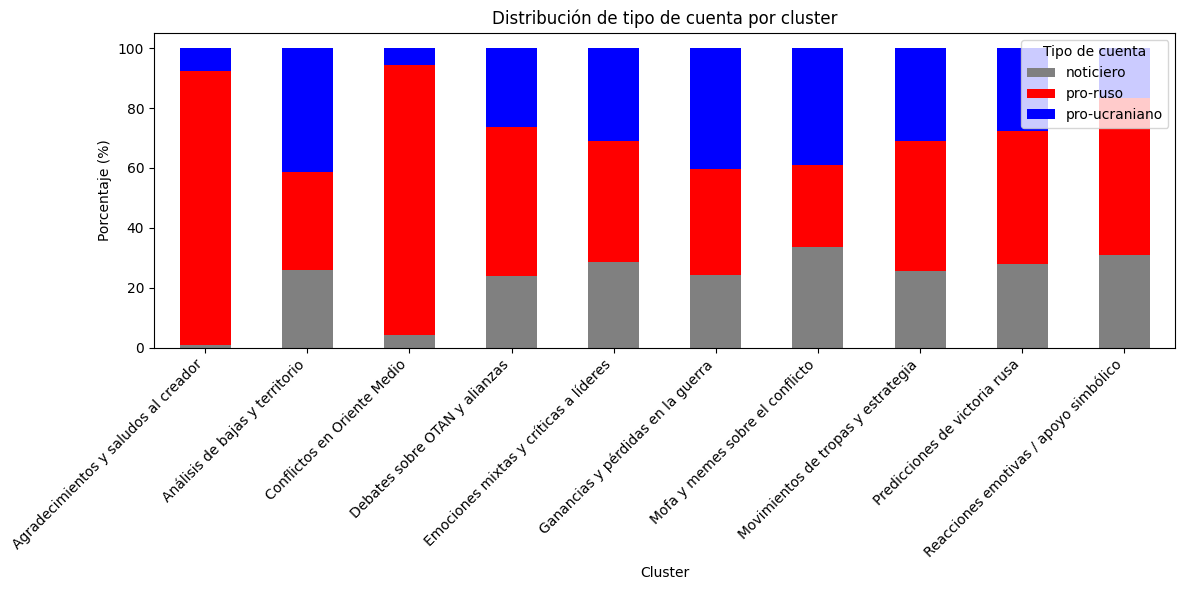

In [105]:
# Gráfico de barras apiladas con rotación de etiquetas
ax = tabla_cruce_cuenta_cluster.plot(
    kind='bar',
    stacked=True,
    color=[colors[col] for col in tabla_cruce_cuenta_cluster.columns],
    figsize=(12, 6)
)

# Rotar etiquetas del eje x para mejor lectura
plt.xticks(rotation=45, ha='right')

plt.xlabel('Cluster')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de tipo de cuenta por cluster')
plt.legend(title='Tipo de cuenta', loc='upper right')
plt.tight_layout()
plt.show()

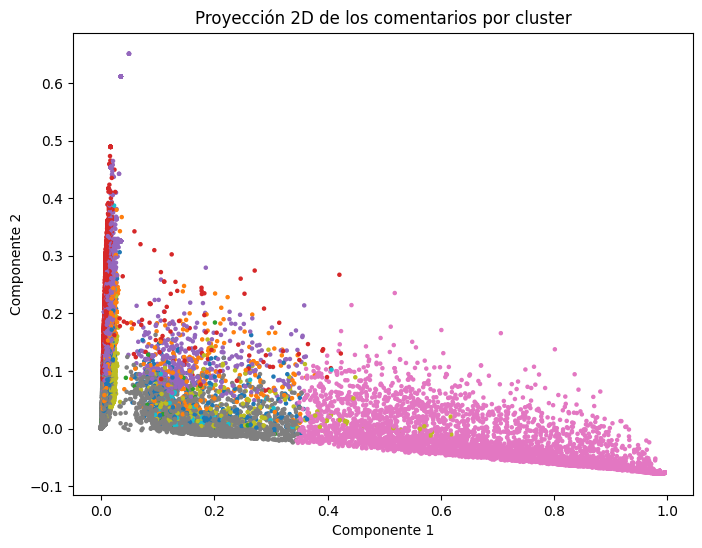

In [96]:
svd2 = TruncatedSVD(n_components=2, random_state=42)
coords = svd2.fit_transform(X)   # usa el mismo X del TF-IDF

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], c=df['cluster'], s=5, cmap='tab10')
plt.title("Proyección 2D de los comentarios por cluster")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113776 entries, 0 to 113775
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comment_id            113776 non-null  object 
 1   comment               113728 non-null  object 
 2   comment_text_length   113776 non-null  int64  
 3   user_id               113776 non-null  object 
 4   user_name             113633 non-null  object 
 5   comment_time          113776 non-null  object 
 6   comment_likes         113776 non-null  int64  
 7   total_reply_count     113776 non-null  int64  
 8   is_top_level_comment  113776 non-null  bool   
 9   video_title           113776 non-null  object 
 10  channel_title         113776 non-null  object 
 11  video_published_at    113776 non-null  object 
 12  video_views           113776 non-null  int64  
 13  video_likes           113776 non-null  int64  
 14  video_duration        113776 non-null  float64
 15  

# Trolls & Bots

In [110]:
# 1) Detectar posibles trolls/bots por user_id
comment_counts = df['user_id'].value_counts()
troll_threshold = 10  # ajusta según lo que consideres sospechoso
troll_users = comment_counts[comment_counts > troll_threshold].index
df['is_troll'] = df['user_id'].isin(troll_users)

In [111]:
# % de trolls/bots por canal y tipo de cuenta
troll_pct = (
    df
    .groupby(['channel_title','condiciones_cuenta'])['is_troll']
    .mean()
    .unstack(fill_value=0) * 100
)

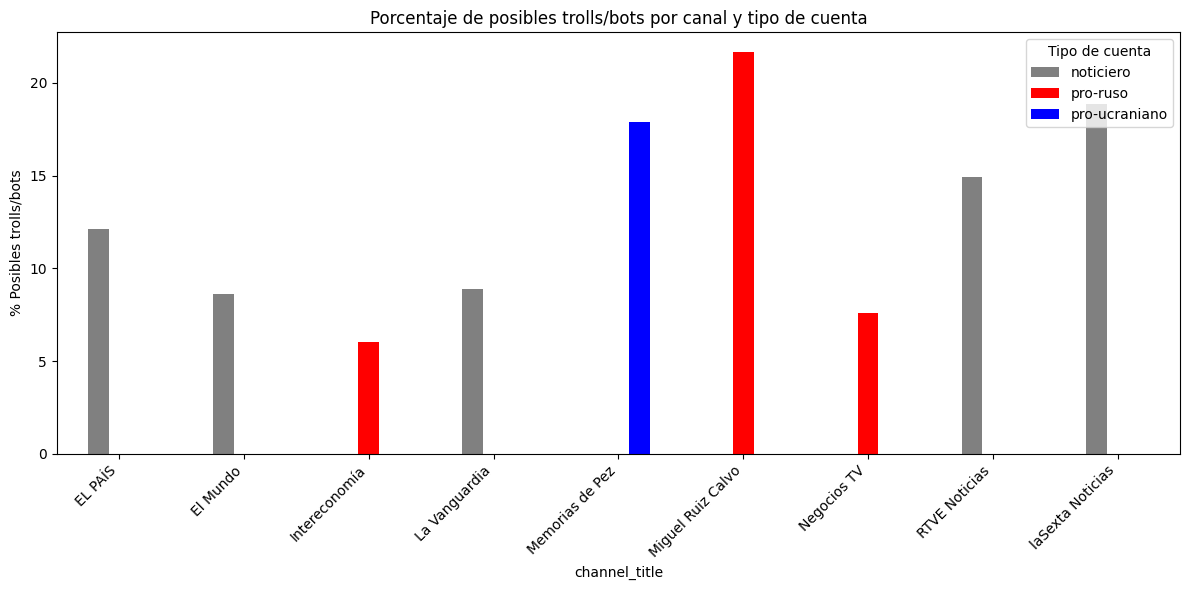

In [113]:
# gráfico de barras agrupadas
ax = troll_pct.plot(
    kind='bar',
    figsize=(12,6),
    color=[colors[c] for c in troll_pct.columns]
)
plt.ylabel('% Posibles trolls/bots')
plt.title('Porcentaje de posibles trolls/bots por canal y tipo de cuenta')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de cuenta', loc='upper right')
plt.tight_layout()
plt.show()

# Terminos específicos

In [114]:
# 2) Detección de términos clave semánticos
terms_map = {
    'NAFO':        ['nafo'],
    'ucranazi':    ['ucranazi'],
    'AZOV':        ['azov'],
    'Bucha':       ['bucha'],
    'termino_ukr': ['guerra','invasion'],          # pro-ucraniano
    'termino_rus': ['operacion','especial','conflicto']  # pro-ruso
}

In [116]:
def normalize_text(text):
    txt = str(text).lower()
    txt = unicodedata.normalize('NFKD', txt)
    return ''.join(c for c in txt if not unicodedata.combining(c))


In [117]:
for col, kws in terms_map.items():
    df[col] = df['comment'].apply(lambda t: any(kw in normalize_text(t) for kw in kws))

In [118]:
# % de uso de cada término por tipo de cuenta
usage_pct = df.groupby('condiciones_cuenta')[list(terms_map)].mean() * 100

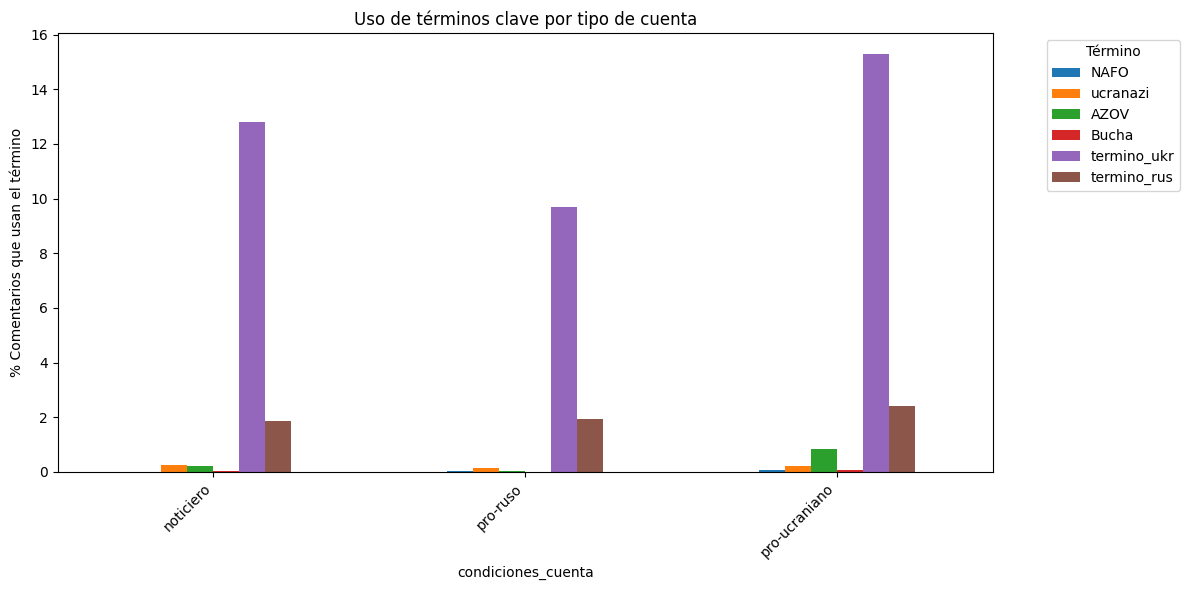

In [119]:
# gráfico de barras agrupadas
usage_pct.plot(
    kind='bar',
    figsize=(12,6),
    color=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
)
plt.ylabel('% Comentarios que usan el término')
plt.title('Uso de términos clave por tipo de cuenta')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Término', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# Identificación de Emociones

In [124]:
# 2) Detección de emociones con lexicón manual (8 categorías)
emotion_lexicon = {
    'joy':          ['feliz','alegria','contento','genial','gracias','excelente'],
    'anger':        ['rabia','enojo','cabreo','odiar','odio','joder'],
    'sadness':      ['triste','lagrima','dolor','perdida'],
    'fear':         ['miedo','temor','peligro','terror'],
    'surprise':     ['sorpresa','increible','wow'],
    'disgust':      ['asco','repugn','nausea'],
    'trust':        ['confianza','seguro','creer','fiable'],
    'anticipation': ['espera','anticipar','futuro']
}


In [125]:
def detect_emotion_rule(text):
    tokens = set(re.findall(r'\b\w+\b', normalize_text(text)))
    scores = {emo: sum(tok in tokens for tok in kws)
              for emo, kws in emotion_lexicon.items()}
    emo, count = max(scores.items(), key=lambda x: x[1])
    return emo if count > 0 else None

df['emotion'] = df['comment'].apply(detect_emotion_rule)

In [ ]:
print(df['emotion'])

# Ejes argumentativos

In [ ]:
candidate_args = [
    "insultos al creador del video",
    "justificacion historica",
    "culpa de la Otan",
    "culpa de Rusia",
    "defensa de acciones rusas",
    "defensa de acciones ucranianas"
]

In [ ]:
# 3) Ejes argumentativos con zero‐shot (modelo distilado para velocidad)
arg_pipeline = pipeline(
    "zero-shot-classification",
    model="valhalla/distilbart-mnli-12-1",
    device=-1, batch_size=32,
    local_files_only=True
)

In [ ]:

def detect_argument(text):
    out = arg_pipeline(str(text), candidate_args)
    return out['labels'][0]

df['argument_axis'] = df['comment'].apply(detect_argument)


In [ ]:
# 4) Resúmenes rápidos
print("Emociones (%):")
print(df['emotion'].value_counts(normalize=True).mul(100).round(1), "\n")

print("Ejes argumentativos (%):")
print(df['argument_axis'].value_counts(normalize=True).mul(100).round(1))

### Ejes argumentativos con ajustes manuales (más rápido)

In [ ]:
# 2) Palabras clave por eje argumentativo
axes_keywords = {
    "insultos_al_creador": ["canal","video","tú","ustedes"],
    "justificacion_historica": ["historia","historica","historico","urss","segunda guerra mundial","nazi","imperio"],
    "culpa_de_la_otan": ["otan","nato","occidente","eeuu","unidos"],
    "culpa_de_rusia": ["invasor","genocida","masacre","criminal"],
    "defensa_acciones_rusas": ["defender","defensa","victoria","vencer","liberacion","desnazific"],
    "defensa_acciones_ucranianas": ["resistencia","resistir","libertad","justicia","liberar"]
}

In [ ]:
# 3) Prioridad de ejes
priority = [
    "insultos_al_creador",
    "justificacion_historica",
    "culpa_de_la_otan",
    "culpa_de_rusia",
    "defensa_acciones_rusas",
    "defensa_acciones_ucranianas"
]

In [ ]:
# 4) Detector de ejes que usa la columna 'insulto'
def detect_argument_rule(row):
    norm = normalize_text(row['comment'])
    # insultos_al_creador solo si ya marcaste insulto True y referencia al canal/video
    if row.get('insulto', False) and any(kw in norm for kw in axes_keywords["insultos_al_creador"]):
        return "insultos al creador del video"
    # los demás ejes por presencia de keywords en orden
    for axis in priority[1:]:
        for kw in axes_keywords[axis]:
            if kw in norm:
                label_map = {
                    "justificacion_historica": "justificación histórica",
                    "culpa_de_la_otan": "culpa de la OTAN",
                    "culpa_de_rusia": "culpa de Rusia",
                    "defensa_acciones_rusas": "defensa de acciones rusas",
                    "defensa_acciones_ucranianas": "defensa de acciones ucranianas"
                }
                return label_map[axis]
    return "neutral"


In [ ]:
# 5) Aplicar al DataFrame
df['argument_axis'] = df.apply(detect_argument_rule, axis=1)